In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Created by: Hang Zhang
## Email: zhanghang0704@gmail.com
## Copyright (c) 2020
##
## LICENSE file in the root directory of this source tree 
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# code adapted from:
# https://github.com/kakaobrain/fast-autoaugment
# https://github.com/rpmcruz/autoaugment
import math
import random

import numpy as np
from collections import defaultdict
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

RESAMPLE_MODE=PIL.Image.BICUBIC

RANDOM_MIRROR = True

def ShearX(img, v, resample=RESAMPLE_MODE):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if RANDOM_MIRROR and random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0),
                         resample=resample)

def ShearY(img, v, resample=RESAMPLE_MODE):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if RANDOM_MIRROR and random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0),
                         resample=resample)


def TranslateX(img, v, resample=RESAMPLE_MODE):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if RANDOM_MIRROR and random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0),
                         resample=resample)


def TranslateY(img, v, resample=RESAMPLE_MODE):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if RANDOM_MIRROR and random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v),
                         resample=resample)


def TranslateXabs(img, v, resample=RESAMPLE_MODE):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0),
                         resample=resample)


def TranslateYabs(img, v, resample=RESAMPLE_MODE):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v),
                         resample=resample)


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if RANDOM_MIRROR and random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = PIL.Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    #assert 4 <= v <= 8
    v = int(v)
    return PIL.ImageOps.posterize(img, v)

def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
    assert 0.0 <= v <= 0.2
    if v <= 0.:
        return img

    v = v * img.size[0]
    return CutoutAbs(img, v)

def rand_augment_list():  # 16 oeprations and their ranges
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l

class RandAugment(object):
    def __init__(self, n, m):
        self.n = n
        self.m = m
        self.augment_list = rand_augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            if random.random() > random.uniform(0.2, 0.8):
                continue
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)
        return img

In [ ]:
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Created by: Hang Zhang
## Email: zhanghang0704@gmail.com
## Copyright (c) 2020
##
## LICENSE file in the root directory of this source tree 
##+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import math
import random

from PIL import Image
from torchvision.transforms import Resize, InterpolationMode

__all__ = ['Lighting', 'ERandomCrop', 'ECenterCrop']

class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone()\
            .mul(alpha.view(1, 3).expand(3, 3))\
            .mul(self.eigval.view(1, 3).expand(3, 3))\
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


#https://github.com/kakaobrain/fast-autoaugment/blob/master/FastAutoAugment/data.py
class ERandomCrop:
    def __init__(self, imgsize, min_covered=0.1, aspect_ratio_range=(3./4, 4./3),
                 area_range=(0.1, 1.0), max_attempts=10):
        assert 0.0 < min_covered
        assert 0 < aspect_ratio_range[0] <= aspect_ratio_range[1]
        assert 0 < area_range[0] <= area_range[1]
        assert 1 <= max_attempts

        self.imgsize = imgsize
        self.min_covered = min_covered
        self.aspect_ratio_range = aspect_ratio_range
        self.area_range = area_range
        self.max_attempts = max_attempts
        self._fallback = ECenterCrop(imgsize)
        self.resize_method = Resize((imgsize, imgsize),
                                    interpolation=InterpolationMode.BILINEAR)

    def __call__(self, img):
        original_width, original_height = img.size
        min_area = self.area_range[0] * (original_width * original_height)
        max_area = self.area_range[1] * (original_width * original_height)

        for _ in range(self.max_attempts):
            aspect_ratio = random.uniform(*self.aspect_ratio_range)
            height = int(round(math.sqrt(min_area / aspect_ratio)))
            max_height = int(round(math.sqrt(max_area / aspect_ratio)))

            if max_height * aspect_ratio > original_width:
                max_height = (original_width + 0.5 - 1e-7) / aspect_ratio
                max_height = int(max_height)
                if max_height * aspect_ratio > original_width:
                    max_height -= 1

            if max_height > original_height:
                max_height = original_height

            if height >= max_height:
                height = max_height

            height = int(round(random.uniform(height, max_height)))
            width = int(round(height * aspect_ratio))
            area = width * height

            if area < min_area or area > max_area:
                continue
            if width > original_width or height > original_height:
                continue
            if area < self.min_covered * (original_width * original_height):
                continue
            if width == original_width and height == original_height:
                return self._fallback(img)

            x = random.randint(0, original_width - width)
            y = random.randint(0, original_height - height)
            img = img.crop((x, y, x + width, y + height))
            return self.resize_method(img)

        return self._fallback(img)


class ECenterCrop:
    """Crop the given PIL Image and resize it to desired size.
    Args:
        img (PIL Image): Image to be cropped. (0,0) denotes the top left corner of the image.
        output_size (sequence or int): (height, width) of the crop box. If int,
            it is used for both directions
    Returns:
        PIL Image: Cropped image.
    """
    def __init__(self, imgsize):
        self.imgsize = imgsize
        self.resize_method = Resize((imgsize, imgsize),
                                    interpolation=InterpolationMode.BILINEAR)

    def __call__(self, img):
        image_width, image_height = img.size
        image_short = min(image_width, image_height)

        crop_size = float(self.imgsize) / (self.imgsize + 32) * image_short

        crop_height, crop_width = crop_size, crop_size
        crop_top = int(round((image_height - crop_height) / 2.))
        crop_left = int(round((image_width - crop_width) / 2.))
        img = img.crop((crop_left, crop_top, crop_left + crop_width, crop_top + crop_height))
        return self.resize_method(img)

In [ ]:

_imagenet_pca = {
    'eigval': torch.Tensor([0.2175, 0.0188, 0.0045]),
    'eigvec': torch.Tensor([
        [-0.5675,  0.7192,  0.4009],
        [-0.5808, -0.0045, -0.8140],
        [-0.5836, -0.6948,  0.4203],
    ])
}

In [ ]:
from torchvision.transforms import *
corp_size = 32
normalize = Normalize(mean=(0.4914, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010))
base_size =  int(1.0 * corp_size / 0.875)
train_transforms = []

train_transforms.append(RandAugment(2, 12))
train_transforms.extend([
        ECenterCrop(corp_size),
        RandomHorizontalFlip(),
        ColorJitter(0.4, 0.4, 0.4),
        ToTensor(),
        normalize,
    ])
transform_train = Compose(train_transforms)

In [ ]:
val_transforms = []
val_transforms.extend([
        ECenterCrop(corp_size),
        ToTensor(),
        normalize,
    ])

transform_test = Compose(val_transforms)

In [ ]:
# check availability of GPU and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

use_cuda =  True# if you have acess to a GPU, enable it to speed the training


In [ ]:
# Load the CIFAR-10 training, test datasets using `torchvision.datasets.CIFAR10`
#### YOUR CODE STARTS HERE ####
# train_dataset = datasets.Places365(root = "./d",  split = 'train-standard',small= True, download = True,  transform = transform_train)
train_dataset = datasets.CIFAR10("./data",train=True,download = True, transform = transform_train)
test_dataset = datasets.CIFAR10("./data",train=False,download = True, transform = transform_test)
# test_dataset = datasets.Places365(root = "./d",  split = 'train-standard',small= True, download = True,  transform = transform_test)
#### YOUR CODE ENDS HERE ####


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:

# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False)
#### YOUR CODE ENDS HERE ####

In [ ]:
policy = RandAugment(16,12)

In [ ]:
img = Image.open("/content/shubham.jpeg")

In [ ]:
import matplotlib.pyplot as plt
def show_sixteen(images, titles=0):
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0, "hspace": 0})
    for idx, ax in enumerate(f.axes):
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

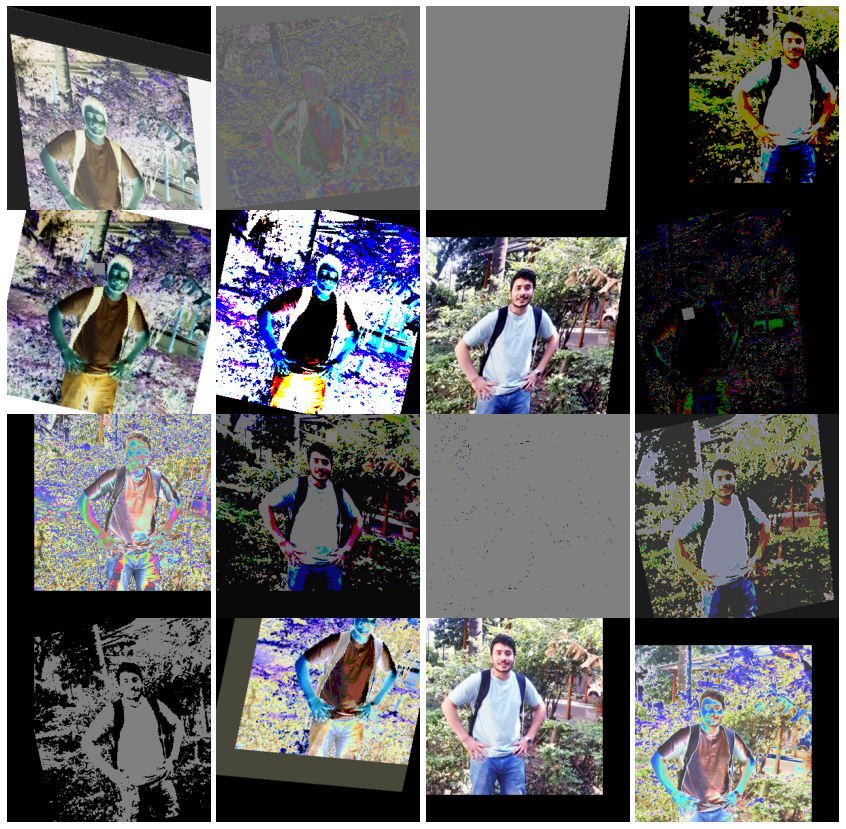

In [ ]:
imgs = []
for _ in range(16): imgs.append(policy(img))
show_sixteen(imgs)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair


In [ ]:
class SplAtConv2d(Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm_layer=None,
                 dropblock_prob=0.0, **kwargs):
        super(SplAtConv2d, self).__init__()
        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        if self.rectify:
            from rfconv import RFConv2d
            self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                                 groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        else:
            self.conv = Conv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                               groups=groups*radix, bias=bias, **kwargs)
        self.use_bn = norm_layer is not None
        if self.use_bn:
            self.bn0 = norm_layer(channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = norm_layer(inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        if dropblock_prob > 0.0:
            self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            if torch.__version__ < '1.5':
                splited = torch.split(x, int(rchannel//self.radix), dim=1)
            else:
                splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            if torch.__version__ < '1.5':
                attens = torch.split(atten, int(rchannel//self.radix), dim=1)
            else:
                attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

In [ ]:
import math
import torch
import torch.nn as nn

class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data = data.to(device)
        target = target.to(device)
        
        # flush out the gradients stored in optimizer
        model.zero_grad()
        
        # pass the image to the model and assign the output to variable named output
        output = model(data)

        # calculate the loss (use cross entropy in pytorch)
        l = nn.CrossEntropyLoss()
        loss = l(output,target)
        
        # do a backward pass
        loss.backward()

        # update the weights
        optimizer.step()

      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data = data.to(device)
            target = target.to(device)

            # pass the image to the model and assign the output to variable named output
            output = model(data)

          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = ResNet(Bottleneck, [3, 4, 6, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=10,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False).to(device)
criterion = nn.CrossEntropyLoss().cuda()
## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(),lr=0.01)
start = timeit.default_timer()
for epoch in range(1, 51):
    train(model, device, train_dataloader, criterion, optimizer, epoch)
    test(model, device, test_dataloader, criterion)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.443202
Train Epoch: 1 [640/50000 (1%)]	Loss: 4.920323
Train Epoch: 1 [1280/50000 (3%)]	Loss: 6.422346
Train Epoch: 1 [1920/50000 (4%)]	Loss: 4.214967
Train Epoch: 1 [2560/50000 (5%)]	Loss: 5.158855
Train Epoch: 1 [3200/50000 (6%)]	Loss: 6.239792
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.210417
Train Epoch: 1 [4480/50000 (9%)]	Loss: 4.196982
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.603957
Train Epoch: 1 [5760/50000 (12%)]	Loss: 3.381201
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.660336
Train Epoch: 1 [7040/50000 (14%)]	Loss: 2.258300
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.770397
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.342767
Train Epoch: 1 [8960/50000 (18%)]	Loss: 3.127126
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.581982
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.718238
Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.256128
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.309854
Train Epoch: 1 [12160/50000 (24%)]	Loss: 2.340067
Train Epoch: 1 [12800/50000 